<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [39]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize

#from shapely.geometry import LineString
#from shapely.geometry import Point

# Some functions

In [79]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


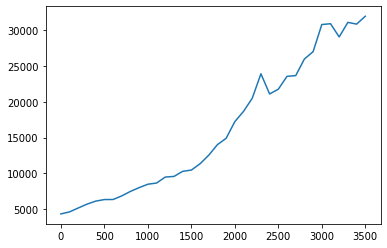

In [ ]:
load_and_plot(time_step=100)

In [ ]:
import pickle 
dbfile = open('ensemble2_100', 'rb')      
systems = pickle.load(dbfile) 

FileNotFoundError: [Errno 2] No such file or directory: 'ensemble2_100'

# Stadium Billiards

In [40]:
def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    
    p = Point(0,h)
    c = p.buffer(l).boundary

    x_left = -l
    x_right = l
    m = (vel_vec[1]/vel_vec[0])
    k = 1
    while k>0:
        y_left = line2cord(m , x, h, x_left)
        y_right = line2cord(m , x, h, x_right)
        #print((x_left,y_left),(x_right, y_right))
        ls = LineString([Point(x_left,y_left), Point(x_right, y_right)])
        inte = c.intersection(ls)
       
        pois = [inte.geoms[0].coords[0], inte.geoms[1].coords[0]]
        print(pois)
        if (pois[0][1]>h) != (pois[1][1]>h):
            print('1yh')
            if pois[0][1]>h:
                x_ =  pois[0][0]
                y_ = pois[0][1]
            else:
                x_ =  pois[1][0]
                y_ = pois[1][1]
            if (x_ - x)/vel_vec[0]< 0:
                print('t dec: x_ , x, u:', x_, x, vel_vec[0] )
            t += (x_ - x)/vel_vec[0]
            x = x_
            y = y_
            if k>0:
                k = -2
                

        elif (pois[0][1]>h and pois[1][1]>h) and (k>0):
            print('2yh')
            #collision inside
            sol1 = pois[0][0]
            sol2 = pois[1][0]
            if x == sol1:
                t += (x - sol2)/vel_vec[0]
                x = sol2
                y = pois[1][1]
            elif x == sol2:
                t += (x - sol1)/vel_vec[0]
                x = sol1
                y = pois[0][1]
            else:
                print('no intersection')


        else:
            #error
            print('err3')

        p = float(d_sem_func(x, r))
        nor_vec = [-np.sign(p), -np.sign(p)*(1/p)]
        nor_vec = normalize(nor_vec)
        #nor_inc = normalize(vel_vec)
        ref = vel_vec - (2*np.dot(nor_inc, vel_vec)*nor_vec)
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        
        if np.linalg.norm(ref) != np.linalg.norm(vel_vec):
            print('unnormalized collision')
        if k== -2:
            if ref[1]>0:
                print('other way')
            del_t = ((h-y)/ref[1])
            if del_t < 0:
                print('t dec_2: y:', y, 'h:', h, 'v:', ref[1])
            print('v')
            t += del_t
            x += ref[0]*del_t
            y = h
            if abs(x) > l:
                print('x:', x, 'x_:', x_)
            return (x, y, ref[0], ref[1], t)
        k += 1
        m = ref[1]/ref[0]

#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    print('t_left:',time_step[0], 't_right:',time_step[1], 
           't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            yf = -h
            vf = -v
            uf = u
            xf = x + u*time_step[di]
            #print('next wall: bottom')
    
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10)
plot_bill(res)


    


t_left: -8.09629893137039 t_right: 16.81539008823081 t_top: 0.25063589562403643 t_bottom: -0.05316518998085621
next wall: semi-circle enclosure


NameError: name 'Point' is not defined

In [ ]:
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


# Stadium Billiards

In [43]:
k = d_sem_func(x = 1, r = 2)
nor_vec = [-np.sign(k), -np.sign(k)*(1/k)]
nor_vec = normalize(nor_vec)
nor_vec 

array([-0.5      , -0.8660254])

In [21]:
x = -23
np.sign(x)

-1

next wall: semi-circle enclosure
entered enclosure: x: -0.6597560975609755 y: 1 u: 0.16056719385235946 v: 6.583254947946738
unnormalized collision
exit enclosure: x: [1.85335822] y: 1 u: [-0.16056719] v: [-6.58325495]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.75339435] y: 1 u: [-0.16056719] v: [6.58548064]
exit enclosure: x: [-0.35938565] y: 1 u: [-5.93527778] v: [-2.85776395]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.86054951] y: 1 u: [-5.93527778] v: [2.86240238]
exit enclosure: x: [-1.52309921] y: 1 u: [4.08933529] v: [-5.16703074]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.713891] y: 1 u: [4.08933529] v: [5.17373222]
exit enclosure: x: [1.61857291] y: 1 u: [-4.84144478] v: [-4.47778747]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.20140257] y: 1 u: [4.84144478] v: [4.48591425]
unnormalized collision
exit enclosure: x: [-1.0094214

exit enclosure: x: [0.87084767] y: 1 u: [-4.6778779] v: [-4.67486196]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80468112] y: 1 u: [4.6778779] v: [4.68781095]
unnormalized collision
exit enclosure: x: [-0.80965362] y: 1 u: [-4.68450228] v: [-4.68119126]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8643259] y: 1 u: [4.68450228] v: [4.69578898]
exit enclosure: x: [0.86138962] y: 1 u: [-4.69202976] v: [-4.68826753]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81616471] y: 1 u: [4.69202976] v: [4.7039362]
exit enclosure: x: [-0.82211949] y: 1 u: [-4.69997074] v: [-4.69600193]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85410547] y: 1 u: [4.69997074] v: [4.71276258]
exit enclosure: x: [0.85076432] y: 1 u: [-4.70850249] v: [-4.70423855]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82933711

exit enclosure: x: [-0.86737875] y: 1 u: [-4.75819543] v: [-4.75398296]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81894675] y: 1 u: [4.75819543] v: [4.76998048]
unnormalized collision
exit enclosure: x: [0.81583017] y: 1 u: [-4.76605537] v: [-4.76212702]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87363591] y: 1 u: [4.76605537] v: [4.777126]
unnormalized collision
exit enclosure: x: [-0.87914818] y: 1 u: [-4.77343864] v: [-4.76974843]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81052463] y: 1 u: [4.77343864] v: [4.78319958]
exit enclosure: x: [0.80793645] y: 1 u: [-4.77994815] v: [-4.7766945]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88420976] y: 1 u: [4.77994815] v: [4.78875019]
exit enclosure: x: [-0.88858947] y: 1 u: [-4.78581798] v: [-4.78288396]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered e

next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89747693] y: 1 u: [4.79890464] v: [4.80068767]
exit enclosure: x: [-0.89836347] y: 1 u: [-4.8000934] v: [-4.79949905]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79875127] y: 1 u: [4.8000934] v: [4.79976767]
unnormalized collision
exit enclosure: x: [0.79883788] y: 1 u: [-4.79987625] v: [-4.79998483]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89779001] y: 1 u: [4.79987625] v: [4.79827038]
exit enclosure: x: [-0.89699139] y: 1 u: [-4.79880573] v: [-4.79934102]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80103791] y: 1 u: [4.79880573] v: [4.79511803]
exit enclosure: x: [0.80201737] y: 1 u: [-4.79634758] v: [-4.79757681]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89458365] y: 1 u: [4.79634758] v: [4.79145257]
exit enclosure: x: [-0.89214813] y: 1 u: 

next wall: semi-circle enclosure
entered enclosure: x: [-0.82094765] y: 1 u: [4.70549685] v: [4.69309138]
unnormalized collision
exit enclosure: x: [-0.81473963] y: 1 u: [-4.69723017] v: [-4.70136533]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86762983] y: 1 u: [4.69723017] v: [4.6857815]
exit enclosure: x: [0.87059557] y: 1 u: [-4.68960083] v: [-4.69341705]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80852195] y: 1 u: [4.68960083] v: [4.67892269]
unnormalized collision
exit enclosure: x: [-0.80317439] y: 1 u: [-4.68248477] v: [-4.68604415]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87575486] y: 1 u: [4.68248477] v: [4.67322342]
exit enclosure: x: [0.87814715] y: 1 u: [-4.67631257] v: [-4.67939969]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79827228] y: 1 u: [4.67631257] v: [4.66805943]
unnormalized collision
exit enclo

unnormalized collision
exit enclosure: x: [-0.80273279] y: 1 u: [-4.67995845] v: [-4.67708338]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86803908] y: 1 u: [4.67995845] v: [4.69015002]
exit enclosure: x: [0.86539213] y: 1 u: [-4.6867553] v: [-4.6833581]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80869315] y: 1 u: [4.6867553] v: [4.6977125]
exit enclosure: x: [-0.81417177] y: 1 u: [-4.69406294] v: [-4.69041054]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85845696] y: 1 u: [4.69406294] v: [4.70616]
exit enclosure: x: [0.85530307] y: 1 u: [-4.70213111] v: [-4.69809875]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82107014] y: 1 u: [4.70213111] v: [4.71470757]
exit enclosure: x: [-0.82735218] y: 1 u: [-4.71051915] v: [-4.70632699]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8478251] y:

entered enclosure: x: [0.7979897] y: 1 u: [4.8022584] v: [4.80138481]
exit enclosure: x: [0.79822201] y: 1 u: [-4.80167602] v: [-4.80196722]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89656583] y: 1 u: [4.80167602] v: [4.7995286]
exit enclosure: x: [-0.89549848] y: 1 u: [-4.80024452] v: [-4.80096032]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80071218] y: 1 u: [4.80024452] v: [4.79603322]
exit enclosure: x: [0.80183065] y: 1 u: [-4.79743739] v: [-4.79884116]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89280708] y: 1 u: [4.79743739] v: [4.79203781]
unnormalized collision
exit enclosure: x: [-0.89012187] y: 1 u: [-4.79383835] v: [-4.79563821]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80603602] y: 1 u: [4.79383835] v: [4.78655291]
unnormalized collision
exit enclosure: x: [0.80796675] y: 1 u: [-4.78898262] v: [-4.7914111]

entered enclosure: x: [-0.83168657] y: 1 u: [4.722343] v: [4.7091004]
exit enclosure: x: [-0.82506873] y: 1 u: [-4.71351873] v: [-4.71793293]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85842467] y: 1 u: [4.71351873] v: [4.70079282]
unnormalized collision
exit enclosure: x: [0.86173193] y: 1 u: [-4.70503861] v: [-4.70928058]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81806054] y: 1 u: [4.70503861] v: [4.69284069]
exit enclosure: x: [-0.81195942] y: 1 u: [-4.69691018] v: [-4.70097616]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86801871] y: 1 u: [4.69691018] v: [4.68574127]
unnormalized collision
exit enclosure: x: [0.87091132] y: 1 u: [-4.68946719] v: [-4.69319017]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80591481] y: 1 u: [4.68946719] v: [4.67910754]
unnormalized collision
exit enclosure: x: [-0.80072948] y: 1 u: [-4.

entered enclosure: x: [0.86589525] y: 1 u: [4.68372223] v: [4.69421449]
exit enclosure: x: [0.8631682] y: 1 u: [-4.69071968] v: [-4.68722226]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80933639] y: 1 u: [4.69071968] v: [4.70194124]
exit enclosure: x: [-0.81494301] y: 1 u: [-4.6982037] v: [-4.69446318]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85613555] y: 1 u: [4.6982037] v: [4.71050046]
exit enclosure: x: [0.8529271] y: 1 u: [-4.70640511] v: [-4.70230619]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82193181] y: 1 u: [4.70640511] v: [4.71913986]
unnormalized collision
exit enclosure: x: [-0.82828812] y: 1 u: [-4.71489877] v: [-4.71065385]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8454156] y: 1 u: [4.71489877] v: [4.72820501]
exit enclosure: x: [0.84192969] y: 1 u: [-4.72377377] v: [-4.71933835]
bottom bar
next wall: l

entered enclosure: x: [-0.89117433] y: 1 u: [4.79868651] v: [4.79290887]
exit enclosure: x: [-0.88830263] y: 1 u: [-4.79483553] v: [-4.7967614]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80590533] y: 1 u: [4.79483553] v: [4.78720339]
exit enclosure: x: [0.80792773] y: 1 u: [-4.78974878] v: [-4.79229283]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8837637] y: 1 u: [4.78974878] v: [4.78111391]
exit enclosure: x: [-0.87946854] y: 1 u: [-4.78399393] v: [-4.78687222]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81375237] y: 1 u: [4.78399393] v: [4.77381568]
unnormalized collision
exit enclosure: x: [0.81644137] y: 1 u: [-4.77721084] v: [-4.78060359]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87356826] y: 1 u: [4.77721084] v: [4.76626399]
unnormalized collision
exit enclosure: x: [-0.86811798] y: 1 u: [-4.76991573] v: [-4.77356

exit enclosure: x: [0.87087733] y: 1 u: [-4.68993009] v: [-4.6935805]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80377576] y: 1 u: [4.68993009] v: [4.67981604]
exit enclosure: x: [-0.79871615] y: 1 u: [-4.68318981] v: [-4.68656116]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87563891] y: 1 u: [4.68318981] v: [4.67459557]
unnormalized collision
exit enclosure: x: [0.87785868] y: 1 u: [-4.67746207] v: [-4.68032682]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.794214] y: 1 u: [4.67746207] v: [4.66992695]
exit enclosure: x: [-0.79044272] y: 1 u: [-4.67244] v: [-4.67495171]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88090469] y: 1 u: [4.67244] v: [4.66676499]
exit enclosure: x: [0.88236802] y: 1 u: [-4.66865743] v: [-4.6705491]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78764979] y: 1

exit enclosure: x: [0.82890298] y: 1 u: [-4.74546259] v: [-4.74098597]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8501637] y: 1 u: [4.74546259] v: [4.758656]
exit enclosure: x: [-0.85673048] y: 1 u: [-4.75426227] v: [-4.74986446]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82192616] y: 1 u: [4.75426227] v: [4.76690642]
exit enclosure: x: [0.81858661] y: 1 u: [-4.76269543] v: [-4.75848071]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86351301] y: 1 u: [4.76269543] v: [4.77479442]
unnormalized collision
exit enclosure: x: [-0.86952934] y: 1 u: [-4.77076483] v: [-4.76673184]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81254564] y: 1 u: [4.77076483] v: [4.78182095]
unnormalized collision
exit enclosure: x: [0.80961659] y: 1 u: [-4.77813842] v: [-4.77445305]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered en

exit enclosure: x: [-0.78838442] y: 1 u: [-4.66971834] v: [-4.66833857]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87701262] y: 1 u: [4.66971834] v: [4.67586546]
unnormalized collision
exit enclosure: x: [0.87542279] y: 1 u: [-4.67381732] v: [-4.67176828]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79221932] y: 1 u: [4.67381732] v: [4.68106259]
unnormalized collision
exit enclosure: x: [-0.79584141] y: 1 u: [-4.67864875] v: [-4.67623366]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87013759] y: 1 u: [4.67864875] v: [4.68763448]
unnormalized collision
exit enclosure: x: [0.86780662] y: 1 u: [-4.68464115] v: [-4.68164591]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80117772] y: 1 u: [4.68464115] v: [4.69451807]
unnormalized collision
exit enclosure: x: [-0.80611156] y: 1 u: [-4.69122807] v: [-4.68793577]
next wall: left
bott

exit enclosure: x: [0.79924964] y: 1 u: [-4.79718676] v: [-4.79474879]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88841187] y: 1 u: [4.79718676] v: [4.80336859]
exit enclosure: x: [-0.89148003] y: 1 u: [-4.80130887] v: [-4.79924826]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79703857] y: 1 u: [4.80130887] v: [4.80556097]
unnormalized collision
exit enclosure: x: [0.79590709] y: 1 u: [-4.80414402] v: [-4.80272665]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89342626] y: 1 u: [4.80414402] v: [4.80714751]
exit enclosure: x: [-0.89491667] y: 1 u: [-4.80614655] v: [-4.80514539]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79554436] y: 1 u: [4.80614655] v: [4.8070687]
unnormalized collision
exit enclosure: x: [0.79529894] y: 1 u: [-4.80676134] v: [-4.80645396]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered 

exit enclosure: x: [-0.84500849] y: 1 u: [-4.74585049] v: [-4.75023727]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83941583] y: 1 u: [4.74585049] v: [4.7323651]
unnormalized collision
exit enclosure: x: [0.84294408] y: 1 u: [-4.73686449] v: [-4.74135963]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83744904] y: 1 u: [4.73686449] v: [4.72341023]
unnormalized collision
exit enclosure: x: [-0.83073835] y: 1 u: [-4.72789924] v: [-4.732384]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85045775] y: 1 u: [4.72789924] v: [4.71466199]
exit enclosure: x: [0.8539071] y: 1 u: [-4.71907853] v: [-4.72349095]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82340148] y: 1 u: [4.71907853] v: [4.706197]
exit enclosure: x: [-0.81697038] y: 1 u: [-4.71049475] v: [-4.7147886]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclo

entered enclosure: x: [0.85992007] y: 1 u: [4.69395518] v: [4.70528654]
exit enclosure: x: [0.85696875] y: 1 u: [-4.70151246] v: [-4.69773533]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81227671] y: 1 u: [4.70151246] v: [4.71345695]
exit enclosure: x: [-0.81823389] y: 1 u: [-4.70947882] v: [-4.70549732]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84968813] y: 1 u: [4.70947882] v: [4.72229457]
exit enclosure: x: [0.84633696] y: 1 u: [-4.71802653] v: [-4.71375461]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82544884] y: 1 u: [4.71802653] v: [4.7311507]
exit enclosure: x: [-0.83198766] y: 1 u: [-4.72678003] v: [-4.7224053]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83877432] y: 1 u: [4.72678003] v: [4.74025517]
unnormalized collision
exit enclosure: x: [0.83523651] y: 1 u: [-4.73576772] v: [-4.731276]
bottom bar
next wall: 

exit enclosure: x: [0.80885796] y: 1 u: [-4.78995934] v: [-4.79285113]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87803916] y: 1 u: [4.78995934] v: [4.78036408]
unnormalized collision
exit enclosure: x: [-0.87327117] y: 1 u: [-4.78356464] v: [-4.78676306]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81513226] y: 1 u: [4.78356464] v: [4.77257491]
exit enclosure: x: [0.81803323] y: 1 u: [-4.77624096] v: [-4.77990421]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86694754] y: 1 u: [4.77624096] v: [4.76458626]
exit enclosure: x: [-0.86115053] y: 1 u: [-4.76847432] v: [-4.77235922]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82521731] y: 1 u: [4.76847432] v: [4.75586726]
exit enclosure: x: [0.82853276] y: 1 u: [-4.76007332] v: [-4.76427568]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8539

bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86148945] y: 1 u: [4.6921532] v: [4.7030185]
unnormalized collision
exit enclosure: x: [0.85866158] y: 1 u: [-4.69939953] v: [-4.69577776]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80866128] y: 1 u: [4.69939953] v: [4.71094557]
exit enclosure: x: [-0.81441842] y: 1 u: [-4.70710004] v: [-4.70325135]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85152057] y: 1 u: [4.70710004] v: [4.71963429]
exit enclosure: x: [0.8482456] y: 1 u: [-4.71545991] v: [-4.71128182]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82150726] y: 1 u: [4.71545991] v: [4.72837772]
unnormalized collision
exit enclosure: x: [-0.82794192] y: 1 u: [-4.72407571] v: [-4.71976977]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84070944] y: 1 u: [4.72407571] v: [4.7374713]
exit enclosure: x: [0.8371

entered enclosure: x: [-0.88531602] y: 1 u: [4.79882316] v: [4.80562819]
unnormalized collision
exit enclosure: x: [-0.88869015] y: 1 u: [-4.80336091] v: [-4.80109257]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79605923] y: 1 u: [4.80336091] v: [4.80828581]
unnormalized collision
exit enclosure: x: [0.79474844] y: 1 u: [-4.80664474] v: [-4.80500311]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89100796] y: 1 u: [4.80664474] v: [4.81033926]
exit enclosure: x: [-0.89283937] y: 1 u: [-4.80910807] v: [-4.80787656]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79398939] y: 1 u: [4.80910807] v: [4.81074475]
unnormalized collision
exit enclosure: x: [0.79355364] y: 1 u: [-4.81019925] v: [-4.80965369]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89334069] y: 1 u: [4.81019925] v: [4.81055071]
unnormalized collision
exit enclosure: x: 

entered enclosure: x: [0.83518983] y: 1 u: [4.75354078] v: [4.74012267]
unnormalized collision
exit enclosure: x: [0.83870522] y: 1 u: [-4.74459959] v: [-4.74907229]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8391191] y: 1 u: [4.74459959] v: [4.73113625]
exit enclosure: x: [-0.83241265] y: 1 u: [-4.73562828] v: [-4.74011606]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84629558] y: 1 u: [4.73562828] v: [4.72225561]
exit enclosure: x: [0.84978486] y: 1 u: [-4.72671737] v: [-4.73117493]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8249854] y: 1 u: [4.72671737] v: [4.713626]
exit enclosure: x: [-0.81845793] y: 1 u: [-4.71799382] v: [-4.72235761]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85683002] y: 1 u: [4.71799382] v: [4.70552978]
exit enclosure: x: [0.86006982] y: 1 u: [-4.70968812] v: [-4.7138428]
bottom bar
next wall: l

next wall: semi-circle enclosure
entered enclosure: x: [0.87559544] y: 1 u: [4.67394205] v: [4.67945367]
unnormalized collision
exit enclosure: x: [0.87416974] y: 1 u: [-4.67761719] v: [-4.67577998]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78820852] y: 1 u: [4.67761719] v: [4.68426096]
unnormalized collision
exit enclosure: x: [-0.79152472] y: 1 u: [-4.68204742] v: [-4.67983282]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86918495] y: 1 u: [4.68204742] v: [4.69049305]
unnormalized collision
exit enclosure: x: [0.86699412] y: 1 u: [-4.68767953] v: [-4.68486432]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79657455] y: 1 u: [4.68767953] v: [4.69706409]
unnormalized collision
exit enclosure: x: [-0.80125533] y: 1 u: [-4.69393799] v: [-4.6908098]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86073123] y: 1 u: [4.69393799] v: [

exit enclosure: x: [-0.78089412] y: 1 u: [-4.67082462] v: [-4.67167036]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88047075] y: 1 u: [4.67082462] v: [4.67042583]
unnormalized collision
exit enclosure: x: [0.88057363] y: 1 u: [-4.67055876] v: [-4.6706917]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78112013] y: 1 u: [4.67055876] v: [4.67144955]
exit enclosure: x: [-0.78156505] y: 1 u: [-4.67115264] v: [-4.67085571]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87860216] y: 1 u: [4.67115264] v: [4.67418104]
unnormalized collision
exit enclosure: x: [0.87781998] y: 1 u: [-4.67317179] v: [-4.67216233]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78369959] y: 1 u: [4.67317179] v: [4.67743091]
exit enclosure: x: [-0.7858261] y: 1 u: [-4.67601163] v: [-4.67459193]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered 

entered enclosure: x: [0.80495887] y: 1 u: [4.78586665] v: [4.79578572]
exit enclosure: x: [0.80232563] y: 1 u: [-4.79248164] v: [-4.78917529]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87748153] y: 1 u: [4.79248164] v: [4.80145707]
unnormalized collision
exit enclosure: x: [-0.88193013] y: 1 u: [-4.79846713] v: [-4.79547532]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79840661] y: 1 u: [4.79846713] v: [4.80578913]
exit enclosure: x: [0.7964591] y: 1 u: [-4.80334971] v: [-4.80090904]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88558709] y: 1 u: [4.80334971] v: [4.80954024]
unnormalized collision
exit enclosure: x: [-0.888654] y: 1 u: [-4.80747761] v: [-4.8054141]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79424279] y: 1 u: [4.80747761] v: [4.81174262]
exit enclosure: x: [0.79310719] y: 1 u: [-4.81032137] v: [-4.8088997]


exit enclosure: x: [0.8506641] y: 1 u: [-4.72591497] v: [-4.73033671]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82119379] y: 1 u: [4.72591497] v: [4.71299181]
exit enclosure: x: [-0.81475402] y: 1 u: [-4.71730346] v: [-4.72161118]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85754702] y: 1 u: [4.71730346] v: [4.70510604]
exit enclosure: x: [0.86071632] y: 1 u: [-4.70917536] v: [-4.71324116]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80809366] y: 1 u: [4.70917536] v: [4.69762329]
exit enclosure: x: [-0.80233249] y: 1 u: [-4.70147713] v: [-4.70532782]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8664985] y: 1 u: [4.70147713] v: [4.69113873]
unnormalized collision
exit enclosure: x: [0.86917629] y: 1 u: [-4.69458739] v: [-4.69803353]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.796802

exit enclosure: x: [-0.81436941] y: 1 u: [-4.71420191] v: [-4.71026442]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84780247] y: 1 u: [4.71420191] v: [4.7269248]
exit enclosure: x: [0.84447445] y: 1 u: [-4.72268765] v: [-4.71844668]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82153554] y: 1 u: [4.72268765] v: [4.73574545]
unnormalized collision
exit enclosure: x: [-0.82802993] y: 1 u: [-4.73139686] v: [-4.72704426]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83692727] y: 1 u: [4.73139686] v: [4.74484942]
exit enclosure: x: [0.83339426] y: 1 u: [-4.74036948] v: [-4.73588529]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83546397] y: 1 u: [4.74036948] v: [4.75383463]
unnormalized collision
exit enclosure: x: [-0.84215396] y: 1 u: [-4.74935049] v: [-4.7448621]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered 

entered enclosure: x: [0.79181925] y: 1 u: [4.81417786] v: [4.81538314]
exit enclosure: x: [0.79149822] y: 1 u: [-4.81498141] v: [-4.81457965]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.89128338] y: 1 u: [4.81498141] v: [4.81490035]
unnormalized collision
exit enclosure: x: [-0.89124324] y: 1 u: [-4.81492737] v: [-4.81495439]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79285392] y: 1 u: [4.81492737] v: [4.81274522]
exit enclosure: x: [0.79343473] y: 1 u: [-4.81347271] v: [-4.8142001]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88965776] y: 1 u: [4.81347271] v: [4.81004048]
exit enclosure: x: [-0.88795795] y: 1 u: [-4.81118483] v: [-4.81232891]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79659593] y: 1 u: [4.81118483] v: [4.8057501]
unnormalized collision
exit enclosure: x: [0.79804012] y: 1 u: [-4.80756236] v: [-4.8093739

exit enclosure: x: [-0.78434815] y: 1 u: [-4.68137651] v: [-4.68369939]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87676669] y: 1 u: [4.68137651] v: [4.67631447]
exit enclosure: x: [0.8780734] y: 1 u: [-4.67800243] v: [-4.67968978]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78191739] y: 1 u: [4.67800243] v: [4.67417272]
unnormalized collision
exit enclosure: x: [-0.78000637] y: 1 u: [-4.67544963] v: [-4.67672621]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87882418] y: 1 u: [4.67544963] v: [4.67371836]
exit enclosure: x: [0.87927093] y: 1 u: [-4.67429552] v: [-4.67487261]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77948057] y: 1 u: [4.67429552] v: [4.67385409]
exit enclosure: x: [-0.77926031] y: 1 u: [-4.67400124] v: [-4.67414838]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87804

exit enclosure: x: [-0.82564117] y: 1 u: [-4.73157854] v: [-4.72725648]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83715871] y: 1 u: [4.73157854] v: [4.74499464]
exit enclosure: x: [0.83363598] y: 1 u: [-4.74052683] v: [-4.73605479]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83306616] y: 1 u: [4.74052683] v: [4.7539897]
exit enclosure: x: [-0.83975166] y: 1 u: [-4.74950632] v: [-4.74501869]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82620661] y: 1 u: [4.74950632] v: [4.76288341]
exit enclosure: x: [0.82268051] y: 1 u: [-4.75842856] v: [-4.75396953]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84702448] y: 1 u: [4.75842856] v: [4.7715294]
unnormalized collision
exit enclosure: x: [-0.85352358] y: 1 u: [-4.76716646] v: [-4.76279951]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.815812

exit enclosure: x: [-0.77876845] y: 1 u: [-4.67525553] v: [-4.67604181]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87837372] y: 1 u: [4.67525553] v: [4.67503561]
exit enclosure: x: [0.87843049] y: 1 u: [-4.67510892] v: [-4.67518222]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77909555] y: 1 u: [4.67510892] v: [4.67617756]
exit enclosure: x: [-0.77962857] y: 1 u: [-4.67582137] v: [-4.67546516]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8763653] y: 1 u: [4.67582137] v: [4.67902077]
exit enclosure: x: [0.87553843] y: 1 u: [-4.67795455] v: [-4.67688808]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78185588] y: 1 u: [4.67795455] v: [4.68237951]
exit enclosure: x: [-0.78406207] y: 1 u: [-4.68090499] v: [-4.67943]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87167838] y: 1 u: [4.68090499] 

entered enclosure: x: [0.81118926] y: 1 u: [4.77546889] v: [4.78732336]
exit enclosure: x: [0.80804898] y: 1 u: [-4.78337514] v: [-4.77942365]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86497261] y: 1 u: [4.78337514] v: [4.79452732]
exit enclosure: x: [-0.87049627] y: 1 u: [-4.79081281] v: [-4.78709542]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80270107] y: 1 u: [4.79081281] v: [4.80068036]
exit enclosure: x: [0.80008019] y: 1 u: [-4.79739343] v: [-4.79410425]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87559919] y: 1 u: [4.79739343] v: [4.80631263]
exit enclosure: x: [-0.88001386] y: 1 u: [-4.80334141] v: [-4.80036834]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79619853] y: 1 u: [4.80334141] v: [4.81060229]
exit enclosure: x: [0.79426635] y: 1 u: [-4.80818321] v: [-4.80576292]
bottom bar
next wall: left
next wall: sem

exit enclosure: x: [0.85854886] y: 1 u: [-4.71387971] v: [-4.71794997]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80612781] y: 1 u: [4.71387971] v: [4.7023115]
exit enclosure: x: [-0.80036662] y: 1 u: [-4.70617073] v: [-4.7100268]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86433884] y: 1 u: [4.70617073] v: [4.69581025]
unnormalized collision
exit enclosure: x: [0.86702387] y: 1 u: [-4.69926628] v: [-4.70271978]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79482917] y: 1 u: [4.69926628] v: [4.68981056]
unnormalized collision
exit enclosure: x: [-0.79011711] y: 1 u: [-4.69296458] v: [-4.69611649]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87132885] y: 1 u: [4.69296458] v: [4.68512772]
unnormalized collision
exit enclosure: x: [0.87335509] y: 1 u: [-4.68774146] v: [-4.69035375]
bottom bar
next wall: left
next wall: semi-cir

entered enclosure: x: [0.83529168] y: 1 u: [4.735279] v: [4.74871877]
exit enclosure: x: [0.83176086] y: 1 u: [-4.74424308] v: [-4.73976315]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83282883] y: 1 u: [4.74424308] v: [4.75770852]
unnormalized collision
exit enclosure: x: [-0.83951007] y: 1 u: [-4.75322428] v: [-4.7487358]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82435826] y: 1 u: [4.75322428] v: [4.76656917]
exit enclosure: x: [0.82083888] y: 1 u: [-4.76212504] v: [-4.75767673]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84675334] y: 1 u: [4.76212504] v: [4.77517332]
exit enclosure: x: [-0.85322104] y: 1 u: [-4.77082786] v: [-4.76647843]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8140256] y: 1 u: [4.77082786] v: [4.78323179]
unnormalized collision
exit enclosure: x: [0.81074302] y: 1 u: [-4.77910073] v: [-4.77496608]

entered enclosure: x: [0.81824474] y: 1 u: [4.78238897] v: [4.77003954]
unnormalized collision
exit enclosure: x: [0.82149863] y: 1 u: [-4.77415957] v: [-4.77827604]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.85176467] y: 1 u: [4.77415957] v: [4.76138189]
exit enclosure: x: [-0.84542412] y: 1 u: [-4.76564492] v: [-4.76990415]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82906603] y: 1 u: [4.76564492] v: [4.75231944]
unnormalized collision
exit enclosure: x: [0.83256321] y: 1 u: [-4.75676541] v: [-4.76120724]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83793908] y: 1 u: [4.75676541] v: [4.74333057]
unnormalized collision
exit enclosure: x: [-0.83126552] y: 1 u: [-4.74781307] v: [-4.75229135]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84018741] y: 1 u: [4.74781307] v: [4.73436285]
exit enclosure: x: [0.84370309] y: 1 u: [-4

exit enclosure: x: [0.78973466] y: 1 u: [-4.81783085] v: [-4.81647274]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88753594] y: 1 u: [4.81783085] v: [4.82065274]
unnormalized collision
exit enclosure: x: [-0.88893075] y: 1 u: [-4.81971229] v: [-4.81877167]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78946915] y: 1 u: [4.81971229] v: [4.82045653]
unnormalized collision
exit enclosure: x: [0.78927083] y: 1 u: [-4.82020847] v: [-4.81996039]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88894089] y: 1 u: [4.82020847] v: [4.81966661]
exit enclosure: x: [-0.88867303] y: 1 u: [-4.81984724] v: [-4.82002786]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79087442] y: 1 u: [4.81984724] v: [4.81721322]
unnormalized collision
exit enclosure: x: [0.79157573] y: 1 u: [-4.81809139] v: [-4.81896939]
bottom bar
next wall: left
next wall: semi-c

entered enclosure: x: [0.84411437] y: 1 u: [4.74161383] v: [4.72835813]
exit enclosure: x: [0.8475741] y: 1 u: [-4.73278082] v: [-4.73719939]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81776187] y: 1 u: [4.73278082] v: [4.71987142]
unnormalized collision
exit enclosure: x: [-0.81134269] y: 1 u: [-4.72417847] v: [-4.72848161]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85443538] y: 1 u: [4.72417847] v: [4.71200042]
exit enclosure: x: [0.8576021] y: 1 u: [-4.71606326] v: [-4.72012261]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80470453] y: 1 u: [4.71606326] v: [4.70453398]
unnormalized collision
exit enclosure: x: [-0.79896704] y: 1 u: [-4.70838021] v: [-4.7122233]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8633609] y: 1 u: [4.70838021] v: [4.69806768]
exit enclosure: x: [0.86603413] y: 1 u: [-4.7015077] v: [-4.70494521]


entered enclosure: x: [0.80374788] y: 1 u: [4.78960102] v: [4.80027374]
exit enclosure: x: [0.80091452] y: 1 u: [-4.79671881] v: [-4.79316123]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87013386] y: 1 u: [4.79671881] v: [4.80652702]
unnormalized collision
exit enclosure: x: [-0.87498377] y: 1 u: [-4.80325984] v: [-4.79999044]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79646708] y: 1 u: [4.80325984] v: [4.81153708]
exit enclosure: x: [0.79426489] y: 1 u: [-4.80877958] v: [-4.8060205]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87917259] y: 1 u: [4.80877958] v: [4.81598279]
exit enclosure: x: [-0.88273251] y: 1 u: [-4.81358292] v: [-4.81118185]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79144215] y: 1 u: [4.81358292] v: [4.81894626]
unnormalized collision
exit enclosure: x: [0.79001329] y: 1 u: [-4.81715914] v: [-4.815371

next wall: semi-circle enclosure
entered enclosure: x: [0.8169569] y: 1 u: [4.78514479] v: [4.77281244]
exit enclosure: x: [0.82020729] y: 1 u: [-4.77692676] v: [-4.78103754]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.85077119] y: 1 u: [4.77692676] v: [4.76416231]
exit enclosure: x: [-0.8444421] y: 1 u: [-4.76842092] v: [-4.77267574]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82776645] y: 1 u: [4.76842092] v: [4.75510268]
unnormalized collision
exit enclosure: x: [0.83126286] y: 1 u: [-4.75954623] v: [-4.76398565]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.83696395] y: 1 u: [4.75954623] v: [4.74611438]
exit enclosure: x: [-0.83029705] y: 1 u: [-4.75059588] v: [-4.75507317]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83888535] y: 1 u: [4.75059588] v: [4.73714171]
unnormalized collision
exit enclosure: x: [0.84240322] y: 

exit enclosure: x: [0.78861562] y: 1 u: [-4.82031381] v: [-4.81893259]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88630811] y: 1 u: [4.82031381] v: [4.82320668]
unnormalized collision
exit enclosure: x: [-0.88773693] y: 1 u: [-4.82224258] v: [-4.82127829]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78830877] y: 1 u: [4.82224258] v: [4.82306113]
exit enclosure: x: [0.78809059] y: 1 u: [-4.8227883] v: [-4.82251545]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8877873] y: 1 u: [4.8227883] v: [4.82232067]
unnormalized collision
exit enclosure: x: [-0.88755631] y: 1 u: [-4.82247655] v: [-4.82263243]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78965154] y: 1 u: [4.82247655] v: [4.81991726]
unnormalized collision
exit enclosure: x: [0.79033314] y: 1 u: [-4.8207705] v: [-4.8216236]
bottom bar
next wall: left
next wall: semi-circle

exit enclosure: x: [0.86459849] y: 1 u: [-4.70454078] v: [-4.70800656]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7927029] y: 1 u: [4.70454078] v: [4.69504408]
exit enclosure: x: [-0.78797774] y: 1 u: [-4.69821178] v: [-4.70137735]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8689286] y: 1 u: [4.69821178] v: [4.69032526]
unnormalized collision
exit enclosure: x: [0.87096896] y: 1 u: [-4.69295557] v: [-4.69558441]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78391069] y: 1 u: [4.69295557] v: [4.68617431]
unnormalized collision
exit enclosure: x: [-0.78053524] y: 1 u: [-4.68843582] v: [-4.69069624]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87353332] y: 1 u: [4.68843582] v: [4.68357263]
unnormalized collision
exit enclosure: x: [0.87478976] y: 1 u: [-4.68519425] v: [-4.68681532]
bottom bar
next wall: left
next wall: semi-cir

next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.84375814] y: 1 u: [4.76634376] v: [4.77943356]
unnormalized collision
exit enclosure: x: [-0.85023691] y: 1 u: [-4.77507428] v: [-4.77071101]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81223092] y: 1 u: [4.77507428] v: [4.78754651]
exit enclosure: x: [0.80892915] y: 1 u: [-4.78339271] v: [-4.7792353]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.85688429] y: 1 u: [4.78339271] v: [4.79528064]
exit enclosure: x: [-0.86276281] y: 1 u: [-4.79132128] v: [-4.78735863]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.80306342] y: 1 u: [4.79132128] v: [4.80211007]
unnormalized collision
exit enclosure: x: [0.80019896] y: 1 u: [-4.7985165] v: [-4.79492024]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.86839428] y: 1 u: [4.7985165] v: [4.80845442]
unnormalized collis

entered enclosure: x: [0.86133561] y: 1 u: [4.69756626] v: [4.70672272]
exit enclosure: x: [0.85895483] y: 1 u: [-4.70367255] v: [-4.70062039]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79359029] y: 1 u: [4.70367255] v: [4.71370454]
exit enclosure: x: [-0.79857367] y: 1 u: [-4.71036292] v: [-4.70701892]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.85243499] y: 1 u: [4.71036292] v: [4.72172033]
exit enclosure: x: [0.84947136] y: 1 u: [-4.71793757] v: [-4.71415176]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.805088] y: 1 u: [4.71793757] v: [4.72990451]
exit enclosure: x: [-0.81102711] y: 1 u: [-4.7259189] v: [-4.72192992]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84221178] y: 1 u: [4.7259189] v: [4.73874616]
unnormalized collision
exit enclosure: x: [0.83885152] y: 1 u: [-4.73447427] v: [-4.73019851]
bottom bar
next wall: 

exit enclosure: x: [-0.88285688] y: 1 u: [-4.81956239] v: [-4.81745736]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78879761] y: 1 u: [4.81956239] v: [4.82396801]
exit enclosure: x: [0.78762323] y: 1 u: [-4.82249992] v: [-4.82103138]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88487806] y: 1 u: [4.82249992] v: [4.82566119]
unnormalized collision
exit enclosure: x: [-0.88643828] y: 1 u: [-4.82460766] v: [-4.8235539]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78716303] y: 1 u: [4.82460766] v: [4.82570335]
unnormalized collision
exit enclosure: x: [0.78687091] y: 1 u: [-4.82533815] v: [-4.82497292]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88663974] y: 1 u: [4.82533815] v: [4.82514757]
exit enclosure: x: [-0.88654568] y: 1 u: [-4.82521109] v: [-4.82527462]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered

entered enclosure: x: [-0.79256993] y: 1 u: [4.708387] v: [4.698654]
unnormalized collision
exit enclosure: x: [-0.78773117] y: 1 u: [-4.70190057] v: [-4.70514491]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86719089] y: 1 u: [4.70190057] v: [4.69374021]
exit enclosure: x: [0.86930312] y: 1 u: [-4.69646191] v: [-4.69918203]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78350598] y: 1 u: [4.69646191] v: [4.68938951]
exit enclosure: x: [-0.77998844] y: 1 u: [-4.69174816] v: [-4.69410563]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87205135] y: 1 u: [4.69174816] v: [4.68656721]
unnormalized collision
exit enclosure: x: [0.87339041] y: 1 u: [-4.68829483] v: [-4.69002182]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7774958] y: 1 u: [4.68829483] v: [4.68434229]
unnormalized collision
exit enclosure: x: [-0.77552956] y: 1 u: [-4.68

entered enclosure: x: [0.84442811] y: 1 u: [4.72310987] v: [4.73558416]
unnormalized collision
exit enclosure: x: [0.84116345] y: 1 u: [-4.73142972] v: [-4.72727162]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81329554] y: 1 u: [4.73142972] v: [4.74430244]
exit enclosure: x: [-0.8196758] y: 1 u: [-4.74001542] v: [-4.73572451]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83366346] y: 1 u: [4.74001542] v: [4.75338808]
exit enclosure: x: [0.83014977] y: 1 u: [-4.74893472] v: [-4.74447716]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82707518] y: 1 u: [4.74893472] v: [4.76238677]
exit enclosure: x: [-0.83373571] y: 1 u: [-4.75790698] v: [-4.75342296]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82270493] y: 1 u: [4.75790698] v: [4.77132685]
unnormalized collision
exit enclosure: x: [0.81916522] y: 1 u: [-4.76685777] v: [-4.762384

exit enclosure: x: [-0.77435954] y: 1 u: [-4.6855934] v: [-4.68653044]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8738574] y: 1 u: [4.6855934] v: [4.68490492]
unnormalized collision
exit enclosure: x: [0.87403531] y: 1 u: [-4.68513443] v: [-4.68536392]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77442469] y: 1 u: [4.68513443] v: [4.6857366]
exit enclosure: x: [-0.77472413] y: 1 u: [-4.68553588] v: [-4.68533516]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.87223823] y: 1 u: [4.68553588] v: [4.68827167]
unnormalized collision
exit enclosure: x: [0.87153051] y: 1 u: [-4.68735992] v: [-4.68644799]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.77669391] y: 1 u: [4.68735992] v: [4.69133485]
unnormalized collision
exit enclosure: x: [-0.77866976] y: 1 u: [-4.69001025] v: [-4.68868527]
next wall: left
bottom bar
next wall: semi-circ

entered enclosure: x: [0.85066441] y: 1 u: [4.71400095] v: [4.72543484]
exit enclosure: x: [0.84767937] y: 1 u: [-4.72162662] v: [-4.71781532]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8042371] y: 1 u: [4.72162662] v: [4.7336581]
unnormalized collision
exit enclosure: x: [-0.81020252] y: 1 u: [-4.72965101] v: [-4.72564051]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84040419] y: 1 u: [4.72965101] v: [4.74252141]
unnormalized collision
exit enclosure: x: [0.837031] y: 1 u: [-4.73823517] v: [-4.73394503]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.81741336] y: 1 u: [4.73823517] v: [4.75139812]
unnormalized collision
exit enclosure: x: [-0.82393322] y: 1 u: [-4.74701453] v: [-4.74262687]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82949872] y: 1 u: [4.74701453] v: [4.76049922]
unnormalized collision
exit enclosure: x: [0.82

exit enclosure: x: [0.78549928] y: 1 u: [-4.82845134] v: [-4.82811146]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88525275] y: 1 u: [4.82845134] v: [4.82818476]
exit enclosure: x: [-0.88512129] y: 1 u: [-4.82827363] v: [-4.82836249]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78694584] y: 1 u: [4.82827363] v: [4.82591623]
unnormalized collision
exit enclosure: x: [0.78757405] y: 1 u: [-4.82670216] v: [-4.82748796]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88344307] y: 1 u: [4.82670216] v: [4.82309889]
unnormalized collision
exit enclosure: x: [-0.8816655] y: 1 u: [-4.82430028] v: [-4.82550137]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79080997] y: 1 u: [4.82430028] v: [4.81871097]
exit enclosure: x: [0.79229699] y: 1 u: [-4.82057479] v: [-4.8224379]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered e

entered enclosure: x: [-0.7911703] y: 1 u: [4.71138214] v: [4.70165565]
unnormalized collision
exit enclosure: x: [-0.78633923] y: 1 u: [-4.70490005] v: [-4.70814221]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.86583342] y: 1 u: [4.70490005] v: [4.69674572]
exit enclosure: x: [0.86794482] y: 1 u: [-4.6994654] v: [-4.70218351]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.78212062] y: 1 u: [4.6994654] v: [4.69239934]
exit enclosure: x: [-0.77860947] y: 1 u: [-4.69475588] v: [-4.69711123]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8706888] y: 1 u: [4.69475588] v: [4.68958005]
exit enclosure: x: [0.87202701] y: 1 u: [-4.69130596] v: [-4.69303123]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.7761218] y: 1 u: [4.69130596] v: [4.68735863]
exit enclosure: x: [-0.77415997] y: 1 u: [-4.68867478] v: [-4.68999055]
next wall: left
botto

entered enclosure: x: [0.7852979] y: 1 u: [4.83012524] v: [4.8295235]
exit enclosure: x: [0.78545836] y: 1 u: [-4.82972409] v: [-4.82992467]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88412883] y: 1 u: [4.82972409] v: [4.82784546]
unnormalized collision
exit enclosure: x: [-0.88320268] y: 1 u: [-4.82847175] v: [-4.82909796]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.7877762] y: 1 u: [4.82847175] v: [4.82453736]
exit enclosure: x: [0.78882409] y: 1 u: [-4.82584918] v: [-4.82716064]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88067176] y: 1 u: [4.82584918] v: [4.82071622]
unnormalized collision
exit enclosure: x: [-0.87814002] y: 1 u: [-4.82242781] v: [-4.8241388]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79285503] y: 1 u: [4.82242781] v: [4.81540429]
unnormalized collision
exit enclosure: x: [0.79472187] y: 1 u: [-4.817

exit enclosure: x: [-0.81597281] y: 1 u: [-4.74525459] v: [-4.74971056]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84334625] y: 1 u: [4.74525459] v: [4.73226993]
unnormalized collision
exit enclosure: x: [0.84673444] y: 1 u: [-4.7366021] v: [-4.74093033]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80883909] y: 1 u: [4.7366021] v: [4.724069]
exit enclosure: x: [-0.80262335] y: 1 u: [-4.72825039] v: [-4.73242809]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8532607] y: 1 u: [4.72825039] v: [4.7166164]
unnormalized collision
exit enclosure: x: [0.85628581] y: 1 u: [-4.72049758] v: [-4.72437558]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79633294] y: 1 u: [4.72049758] v: [4.70960526]
exit enclosure: x: [-0.79092699] y: 1 u: [-4.71323882] v: [-4.7168696]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclo

entered enclosure: x: [0.85716384] y: 1 u: [4.70582852] v: [4.71535349]
exit enclosure: x: [0.85468421] y: 1 u: [-4.71218064] v: [-4.70900565]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79220359] y: 1 u: [4.71218064] v: [4.72254485]
unnormalized collision
exit enclosure: x: [-0.79734111] y: 1 u: [-4.71909265] v: [-4.71563791]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84803751] y: 1 u: [4.71909265] v: [4.73071528]
unnormalized collision
exit enclosure: x: [0.84500082] y: 1 u: [-4.72684425] v: [-4.72297003]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.8039755] y: 1 u: [4.72684425] v: [4.7390337]
unnormalized collision
exit enclosure: x: [-0.81001218] y: 1 u: [-4.73497404] v: [-4.73091088]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83768229] y: 1 u: [4.73497404] v: [4.74794871]
exit enclosure: x: [0.8342791] y: 1 u: [-4.74

exit enclosure: x: [-0.8833515] y: 1 u: [-4.83172927] v: [-4.83191223]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78555115] y: 1 u: [4.83172927] v: [4.82909562]
exit enclosure: x: [0.78625314] y: 1 u: [-4.82997367] v: [-4.83085155]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.88152439] y: 1 u: [4.82997367] v: [4.8261011]
exit enclosure: x: [-0.8796159] y: 1 u: [-4.8273923] v: [-4.82868316]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.78962625] y: 1 u: [4.8273923] v: [4.82155013]
exit enclosure: x: [0.7911808] y: 1 u: [-4.8234983] v: [-4.82544569]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.87605828] y: 1 u: [4.8234983] v: [4.81654191]
exit enclosure: x: [-0.87262784] y: 1 u: [-4.81886182] v: [-4.82118062]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.79613578] y: 1 u: [4.81886182] v: [

exit enclosure: x: [-0.80201475] y: 1 u: [-4.72730248] v: [-4.72355122]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84293701] y: 1 u: [4.72730248] v: [4.73961475]
exit enclosure: x: [0.8397142] y: 1 u: [-4.73551422] v: [-4.73141013]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80897159] y: 1 u: [4.73551422] v: [4.74826188]
unnormalized collision
exit enclosure: x: [-0.81527908] y: 1 u: [-4.74401647] v: [-4.73976725]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.83224942] y: 1 u: [4.74401647] v: [4.7573254]
unnormalized collision
exit enclosure: x: [0.82875196] y: 1 u: [-4.75289323] v: [-4.74845692]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.82265071] y: 1 u: [4.75289323] v: [4.76632078]
exit enclosure: x: [-0.82928781] y: 1 u: [-4.76184914] v: [-4.75737329]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered 

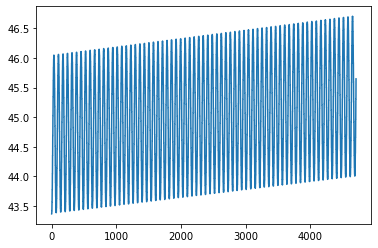

In [157]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        #print('x:', x, 'y:', y)
        #print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            #print('sol1:', sol1, 'sol2:', sol2)
            #print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    #print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    #print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        #print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            #print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        #print('ref:', ref, 'ref shape:', ref.shape)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        #print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            print('next wall: left')
        else:
            xf = l
            print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            print('bottom bar')
            tf1 = tf - s/v
            tf2 = tf + s/v
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf2 = xf1 + u*(tf2-root)
                if abs(xf2)>l:
                    if abs(xf2%(4*l)) > l:
                        xf2 = xf2%(4*l)
                        if abs(xf2) > (3*l):
                            xf2 = (-np.sign(xf2)*4*l)- xf2
                        elif abs(xf2) > l:
                            xf2 = (np.sign(xf2)*2*l)- xf2
                    
                xf = xf2
                yf = -h
                uf = u
                if abs(xf2)>l:
                    print('out!')
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    


    


In [92]:

def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while k<5:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        print('x:', x, 'y:', y)
        print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            print('sol1:', sol1, 'sol2:', sol2)
            print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx != ty:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if x == sol1:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        print('ref:', ref, 'ref shape:', ref.shape)
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
semicircle_enclosure(x=-1.30463345, y=h , u=-0.70840413, v=0.70580705, t=0, lam=1, l=l, h=h, s=s, omega=omega)        

entered enclosure: x: -1.30463345 y: 1 u: -0.70840413 v: 0.70580705
x: -1.30463345 y: 1
disc: 25.12445421870378
sol1: -1.9076308139462042 sol2: 0.607789047199327
ysol1: 1.600786715634544 ysol2: -0.9054113661108811
first collision
p: -3.175221362761635
nor vec: [ 1.         -0.31493867]
ref: [[0.98501219]
 [0.17248476]] ref shape: (2, 1)
x: -1.9076308139462042 y: 1.600786715634544 vel_vec: [[0.98501219]
 [0.17248476]] m: [0.17510927]
x: -1.9076308139462042 y: 1.600786715634544
disc: [12.99497945]
sol1: [-1.90763081] sol2: [1.58997615]
ysol1: [1.60078672] ysol2: [2.21325011]
p: 1.3105097919922755
nor vec: [-1.         -0.76306183]
ref: [[-0.42642001]
 [-0.90452528]] ref shape: (2, 1)
x: [1.58997615] y: [2.21325011] vel_vec: [[-0.42642001]
 [-0.90452528]] m: [2.12120736]
x: [1.58997615] y: [2.21325011]
disc: [69.33996907]
sol1: [0.07583284] sol2: [1.58997615]
ysol1: [-0.99856183] ysol2: [2.21325011]
last collision
failed!: tx [1.34131145] ty [1.34131145]
exit enclosure: x: [1.0180141] y: 

(array([1.0180141]),
 1,
 array([-0.42642001]),
 array([-0.90452528]),
 array([5.74334285]))

In [156]:
from sklearn.preprocessing import normalize
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        print(ref)
        m = float(ref[1]/ref[0])
        
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
trapezium_enclosure(x=0, y=h , u=1, v=1, t=0, lam=1, l=l, h=h, s=s, omega=omega)  
                              

3
vert
[[-1.]
 [ 1.]]
1.0
slop
[[ 1.]
 [-1.]]
1.0
vert
[[-1.]
 [-1.]]
3
exit


(array([0.]), 1, array([-1.]), array([-1.]), array([6.]))